##**YOLOv3 Implementation on Google Colab.**

This is an implementation of YOLOv3 for the por man like me that doesn't have a CPU.

##Utilitaries examples:

### Download a file from github
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/examples/detector.c

###  Rename a file, in this case is stored in the folder content/darknet/weights
!mv weights/_darknet-tiny_900.weights weights/yolo3-tiny.conv.22.900

### Find a group of files inone folder and move to other folder
!find ./backup -name '*.weights' -exec mv --target-directory='./weights/' '{}' +

### Change the permissions of the file
!chmod +x _darknet-tiny_train.txt

### Print the active directory
!pwd

### List all files
!ls -la *.txt

### Unmount the google drive
!fusermount -u /gdrive

### Check a string inside of a file
!grep "OPENCV=" Makefile

### View the tabs, indent and end of line characters of a file
!cat -e -t -v detector.c

### Playing with dictionaries
- print([x for x in thisdict])
- print(len(thisdict))
- for x, y in thisdict.items():
-   print(x, y)

**Step 0:  **These are utility routines that i will use in all the example.  You do not need to worry about modifying files, the script will did it for you.

In [0]:
#
# Mount the drive
#
 def gdrive_mount(path):
    from google.colab import drive
    
    
    drive.mount(path)
    
#
# Mount the drive
#
 def gdrive_umount(path):
   !fusermount -u path

#
# Import a file or files to a destination folder
#
def import_file_to(folder):
  import os
  from google.colab import files  
  
  
  if os.path.exists(folder):
    os.chdir(folder)
  else:
    print('The given path does not exists in the file system')
    return
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

    
#    
# Original File from the LearnOpenCV github
# https://raw.githubusercontent.com/spmallick/learnopencv/master/YOLOv3-Training-Snowman-Detector/splitTrainAndTest.py
#
def split_data_set(image_dir, test_set_percentage):
  import random
  import os
  import subprocess
  import sys

  
  f_val = open("_yolov3-tiny_test.txt", 'w')
  f_train = open("_yolov3-tiny_train.txt", 'w')

  path, dirs, files = next(os.walk(image_dir))
  data_size = len(files)

  ind = 0
  data_test_size = int(test_set_percentage * data_size)
  test_array = random.sample(range(data_size), k=data_test_size)

  for f in os.listdir(image_dir):
    if(f.split(".")[1] == "jpg"):
      ind += 1
      if ind in test_array:
        f_val.write(image_dir+'/'+f+'\n')
      else:
        f_train.write(image_dir+'/'+f+'\n')

#        
# Original File from the LearnOpenCV github
# https://raw.githubusercontent.com/spmallick/learnopencv/master/YOLOv3-Training-Snowman-Detector/getDataFromOpenImages_snowman.py
# classes will be in the format ["person", "cat", "dog"]
#

def download_openimages(classes):
    import csv
    import subprocess
    import os

    
    runMode = "train"
    classes = classes

    with open('class-descriptions-boxable.csv', mode='r') as infile:
      reader = csv.reader(infile)
      dict_list = {rows[1]:rows[0] for rows in reader}

    subprocess.run(['rm', '-rf', 'img'])
    subprocess.run([ 'mkdir', 'img'])

    subprocess.run(['rm', '-rf', 'lbl'])
    subprocess.run([ 'mkdir', 'lbl'])

    for ind in range(0, len(classes)):
    
      className = classes[ind]
      print("Class " + str(ind) + " : " + className)

      commandStr = "grep " + dict_list[className] + " " + runMode + "-annotations-bbox.csv"
      print(commandStr)
      class_annotations = subprocess.run(commandStr.split(), stdout=subprocess.PIPE).stdout.decode('utf-8')
      class_annotations = class_annotations.splitlines()

      totalNumOfAnnotations = len(class_annotations)
      print("Total number of annotations : "+str(totalNumOfAnnotations))

      cnt = 0
      for line in class_annotations[0:totalNumOfAnnotations]:
        cnt = cnt + 1
        print("annotation count : " + str(cnt))
        lineParts = line.split(',')
        subprocess.run([ 'aws', 's3', '--no-sign-request', '--only-show-errors', 'cp', 's3://open-images-dataset/'+runMode+'/'+lineParts[0]+".jpg", 'img/'+lineParts[0]+".jpg"])
        with open('lbl/%s.txt'%(lineParts[0]),'a') as f:
            f.write(' '.join([str(ind),str((float(lineParts[5]) + float(lineParts[4]))/2), str((float(lineParts[7]) + float(lineParts[6]))/2), str(float(lineParts[5])-float(lineParts[4])),str(float(lineParts[7])-float(lineParts[6]))])+'\n')

        
#
# get platform information
#
def get_platform_info():
  import platform
  
  
  # print platform info
  print(platform.platform())
  # print nvidia drivers information, for fun
  !cat /proc/driver/nvidia/version
  !nvcc -V
  !nvidia-smi

#
#
#
def plot_image(img_file_path):
  import matplotlib.pyplot as plt
  import matplotlib.image as mpimg
  import numpy as np
  import os


  if os.path.exists(img_file_path):
    img     = mpimg.imread(img_file_path)
    imgplot = plt.imshow(img, aspect='auto')
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)

  else:
    print('Please verify the specified path or file extension')


#
# Download a file to a directory
#

def fdownload(dest_path, url):
  import os
  import urllib.request
  
  
  fname = url.split('/')[-1]
  os.chdir(dest_path)
  if not os.path.exists(fname):
    print('[INFO] - Downloading ' + fname + ' from: ' + url)
    response = urllib.request.urlopen(url)
    info = response.read()
    info = info.decode("utf-8")
    with open(fname, 'w') as f:
      f.write(info)
      f.close()
    print('[INFO] - ' + fname + ' download completed successfully to ' + dest_path)
  else:
    print('[INFO] - The file ' + fname + ' already exists in ' + dest_path + '.')

    

def fmodifylines(dest_path, fname, linedict):
  with open(fname, 'r+') as f:
    lines = f.readlines()
    for line, value in linedict.items():
      svalue = str(value.split('\n')[0])
      print('[INFO] - Replacing line ' + str(line) + ' in ' + fname + ' as ' + svalue)
      lines[line] = value
    text = ''.join(lines)
    f.close()
  with open(fname, 'w') as f:
    f.write(text)
    f.close()
  print('[INFO] - File modification of ' + fname + ' completed and stored in ' + dest_path)
    
    
#
# Automatically change flags
#
def modify_makefile(EnGPU = 1, EnCUDNN = 0, EnOpenCV = 0, darknetdir='/content/darknet/'):
  import os
  import urllib.request
  
  
  MakefileDict = {
      0:"GPU=" + str(EnGPU) + '\n',
      1:'CUDNN=' + str(EnCUDNN) + '\n',
      2:'OPENCV=' + str(EnOpenCV) + '\n',
      6:'ARCH= -gencode arch=compute_37,code=sm_37 \\' + '\n'
  }
  url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/Makefile'
  os.chdir(darknetdir)
  fdownload(darknetdir, url)
  fname = url.split('/')[-1]
  fmodifylines(darknetdir, fname, MakefileDict)  
  
  
#
# Automatically change line of file
#
def modify_detector_c(coarse=1000, fine=200, detectordir='/content/darknet/examples/'):
  import os
  import urllib.request
  
  
  DetectorDict = {
      137:'        if(i%' + str(coarse) + '==0 || (i < ' + str(fine*10) + ' && i%' + str(fine)+ ' == 0)){' + '\n'
  }
  url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/examples/detector.c'    
  detectordir = darknetdir + detectordir
  os.chdir(detectordir)
  fdownload(detectordir, url)
  fname = url.split('/')[-1]
  fmodifylines(detectordir, fname, DetectorDict)  
  

def make_yolov3_tiny_files(f, datadir, weights):
  from shutil import copyfile as cp
  
  
  cp(cfgdir + fname, cfgdir)
  
  
def create_dir(fdir):
  if not os.path.exists(fdir):
    os.mkdir(fdir)
    print("[INFO] - Created " + fdir)
  else:
    print("[INFO] - Directory " + fdir + " already exists.")
  

In [406]:
# just printing the linux information, i wanted to know :D
get_platform_info()

Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
NVRM version: NVIDIA UNIX x86_64 Kernel Module  410.79  Thu Nov 15 10:41:04 CST 2018
GCC version:  gcc version 4.9.x 20150123 (prerelease) (4.9.2_cos_gg_4.9.2-r193-ac6128e0a17a52f011797f33ac3e7d6273a9368d_4.9.2-r193) 
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
Sun Mar 31 03:12:43 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |

**Step :  **First we are removing all non necessary information about the NVIDIA drivers (if there are in the system).  We are also installing the Amazon Web Services Command Line Interface that is needed to get the files from OpenImages

In [407]:
!rm -rf ~/.nv
!pip3 install awscli

In [0]:
%matplotlib inline
import os
import shutil as shu

# Compilation flags
# Makefile flags, the Makefile is located on /content/darknet/ folder
EnGPU    = 1
EnCUDNN  = 0
EnOpenCV = 0
# Coarse and fine parameters. 
# if "fine" is 200 it tells us to save the weights each 200 epochs up to "coarse"
# if "coarse" is 2000 it is for saving weights over 1000 at each 2000 epochs 
coarse = 2000
fine   = 200


# [Future]
# This will be the path of your Dataset Folder for YOLOv3 in Google Drive
gdrive_imgs = '/gdrive/My Drive/Datasets/YOLOv3/imgs' # images from openimages
gdrive_lbls = '/gdrive/My Drive/Datasets/YOLOv3/lbls' # labels of those images

# This will be the path of the darknet folder on your Colab VM
darknetdir = '/content/darknet/' # where the darknet directory is

# This paths will be based on the /content/darknet/ directory
darknetdir = '/content/darknet/'
weightsdir = 'weights/'         # we will create the yolov3 weights directory
cfgdir     = 'cfg/'             # the configuration directory
imgdir     = 'img/'             # where the images are?
lbldir     = 'lbl/'             # where the lables are?
img        = 'predictions.jpg'  # the predicted file after 'detect' using ./darknet
detectordir = 'examples/'       # the directory where detector.c is


**Step 2:  ** Next, we will get the darknet origintal repository, we will clone to the machine, initially is stored in the ''/content'' folder.

In [0]:
# Check if the darknet folder exists, if not clone and finally change to
# the darknet folder, print only for getting sure we are there
if not os.path.exists(darknetdir):
  !git clone https://github.com/pjreddie/darknet
os.chdir(darknetdir)

**Step :  **We are downloading OpenImages training set file as csv and the classes file as csv too.

In [410]:
# Get openimages class descriptions and annotations of the training set data
!wget https://storage.googleapis.com/openimages/2018_04/class-descriptions-boxable.csv
!wget https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv

--2019-03-31 03:12:52--  https://storage.googleapis.com/openimages/2018_04/class-descriptions-boxable.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.15.128, 2a00:1450:400c:c0c::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.15.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11255 (11K) [text/csv]
Saving to: ‘class-descriptions-boxable.csv.1’

class-descriptions- 100%[===================>]  10.99K  --.-KB/s    in 0s      

2019-03-31 03:12:52 (62.5 MB/s) - ‘class-descriptions-boxable.csv.1’ saved [11255/11255]

--2019-03-31 03:12:53--  https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.166.128, 2a00:1450:400c:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.166.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1194033454 (1.1G) [text/csv]
Saving to: ‘tr

**Step 3:  **Removing the weights directory if exists and downloading the pretrained weights of the full version of yolo and the tiny version of yolo, also we download the suggested original weights.

In [411]:
# delete the weights folder and its content (if exists), if you have ...
# ... models there please backup first
if os.path.exists(weightsdir):
  shu.rmtree(weightsdir)

# making the weights directory and change to that directory
!mkdir weights
os.chdir(weightsdir)

!wget https://pjreddie.com/media/files/darknet53.conv.74   # get the yolov3 original weights (darknet53.conv.74)
!wget https://pjreddie.com/media/files/yolov3.weights      # get the yolov3 pretrained weights (yolov3.weights)
!wget https://pjreddie.com/media/files/yolov3-tiny.weights # get the yolov3 tiny weights (yolov3-tiny.weights)

# finally get into the darknet directory
os.chdir(darknetdir)

--2019-03-31 03:13:09--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.3.39
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  22.0MB/s    in 7.7s    

2019-03-31 03:13:17 (20.1 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]

--2019-03-31 03:13:18--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.3.39
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  22.4MB/s    in 11s     

2019-03-31 03:13:30 (20.6 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2019-03-3

**Step 4:**  I made this change programmatically but you could try it manually
- 4.1 - Download the Makefile from the darknet folder (the folder is located on /content/darknet/Makefile)
- 4.2 - Open the downladed Makefile in your machine
- 4.3 - Modify the line number 1, 2, 3 as you wish i.e.:  GPU=1, OPENCV=0, CUDNN = 0
- 4.4 - Modify the line number 7 to: ARCH= -gencode arch=compute_37,code=sm_37 \
- 4.5 - The lines above compile for GPU support and for the Tesla K80 GPU.  Finally, save the file in your computer.
- 4.6 - Rename or remove the Makefile from the darknet folder in the filesystem, because if you upload the file it will create a new Makefile (1) and will follow the original, not the new one.
- 4.7 - Upload the new Makefile.
- 4.8 - Run the code below

In [412]:
modify_makefile(EnGPU=EnGPU, EnCUDNN=EnCUDNN, EnOpenCV=EnOpenCV, darknetdir=darknetdir)

[INFO] - The file Makefile already exists in /content/darknet/.
[INFO] - Replacing line 0 in Makefile as GPU=1
[INFO] - Replacing line 1 in Makefile as CUDNN=0
[INFO] - Replacing line 2 in Makefile as OPENCV=0
[INFO] - Replacing line 6 in Makefile as ARCH= -gencode arch=compute_37,code=sm_37 \
[INFO] - File modification of Makefile completed and stored in /content/darknet/


In [413]:
modify_detector_c(coarse=coarse, fine=fine, detectordir=detectordir)

[INFO] - The file detector.c already exists in /content/darknet/examples/.
[INFO] - Replacing line 137 in detector.c as         if(i%2000==0 || (i < 2000 && i%200 == 0)){
[INFO] - File modification of detector.c completed and stored in /content/darknet/examples/


**Step 5:**  Just printing the flags and line modified before compiling.  Finally compilig darknet for GPU support and the Tesla K80

In [414]:
os.chdir(darknetdir)
!grep "GPU=" Makefile
!grep "CUDNN=" Makefile
!grep "OPENCV=" Makefile
!grep "code=sm_37" Makefile
os.chdir(darknetdir+detectordir)
!grep "&& i%" detector.c
os.chdir(darknetdir)

GPU=1
CUDNN=0
OPENCV=0
ARCH= -gencode arch=compute_37,code=sm_37 \
        if(i%2000==0 || (i < 2000 && i%200 == 0)){


**Step:  **Finally make the file darknet that is stored in /content/darknet

In [415]:
!make

gcc -Iinclude/ -Isrc/ -DGPU -I/usr/local/cuda/include/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -DGPU -c ./src/gemm.c -o obj/gemm.o
./src/gemm.c: In function ‘time_gpu’:
./src/gemm.c:232:9: warning: ‘cudaThreadSynchronize’ is deprecated [-Wdeprecated-declarations]
         cudaThreadSynchronize();
         ^~~~~~~~~~~~~~~~~~~~~
In file included from /usr/local/cuda/include/cuda_runtime.h:96:0,
                 from include/darknet.h:11,
                 from ./src/utils.h:5,
                 from ./src/gemm.c:2:
/usr/local/cuda/include/cuda_runtime_api.h:947:57: note: declared here
 extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadSynchronize(void);
                                                         ^~~~~~~~~~~~~~~~~~~~~
gcc -Iinclude/ -Isrc/ -DGPU -I/usr/local/cuda/include/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -DGPU -c ./src/utils.c -o obj/utils.o
gcc -Iinclude/ -Isrc/ -DGPU -I/usr/local/cuda/

**Step 6:**  Use the generated darknet framework to evaluate yolov3 with the horses sample.

When finished you could double click on the predictions.jpg file located on the darket folder to check the inference and localization.

In [416]:
!./darknet detect cfg/yolov3.cfg weights/yolov3.weights data/horses.jpg

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

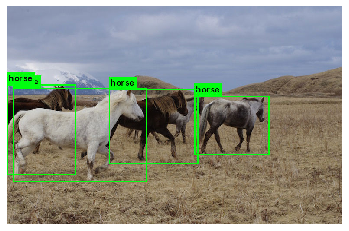

In [417]:
plot_image(img)

**Step 7:**  Just checking the inference of the yolov3 tiny network, remember that this will be less accurrate but more compact than the full yolo.  

We must train the network to improve tha acurracy.

You could check finally the file predictions. Probably yolo will misclassify the horses to other animals and also do not localize well the objects (horses).

In [418]:
!./darknet detect cfg/yolov3-tiny.cfg weights/yolov3-tiny.weights data/horses.jpg

layer     filters    size              input                output
    0 conv     16  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  16  0.150 BFLOPs
    1 max          2 x 2 / 2   416 x 416 x  16   ->   208 x 208 x  16
    2 conv     32  3 x 3 / 1   208 x 208 x  16   ->   208 x 208 x  32  0.399 BFLOPs
    3 max          2 x 2 / 2   208 x 208 x  32   ->   104 x 104 x  32
    4 conv     64  3 x 3 / 1   104 x 104 x  32   ->   104 x 104 x  64  0.399 BFLOPs
    5 max          2 x 2 / 2   104 x 104 x  64   ->    52 x  52 x  64
    6 conv    128  3 x 3 / 1    52 x  52 x  64   ->    52 x  52 x 128  0.399 BFLOPs
    7 max          2 x 2 / 2    52 x  52 x 128   ->    26 x  26 x 128
    8 conv    256  3 x 3 / 1    26 x  26 x 128   ->    26 x  26 x 256  0.399 BFLOPs
    9 max          2 x 2 / 2    26 x  26 x 256   ->    13 x  13 x 256
   10 conv    512  3 x 3 / 1    13 x  13 x 256   ->    13 x  13 x 512  0.399 BFLOPs
   11 max          2 x 2 / 1    13 x  13 x 512   ->    13 x  13 x 512
   12 con

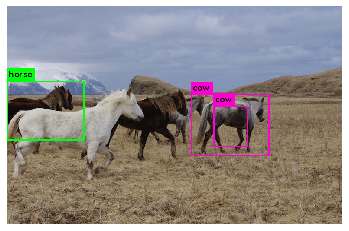

In [419]:
plot_image(img)

In [420]:
os.chdir(darknetdir)
fdir = darknetdir + imgdir
create_dir(fdir)
fdir = darknetdir + lbldir
create_dir(fdir)

[INFO] - Directory /content/darknet/img/ already exists.
[INFO] - Directory /content/darknet/lbl/ already exists.


In [0]:
#Download Dataset

fdir = darknetdir
os.chdir(fdir)
classes = ["Person"]
download_openimages(classes)

Class 0 : Person
grep /m/01g317 train-annotations-bbox.csv
Total number of annotations : 1034721
annotation count : 1
annotation count : 2
annotation count : 3
annotation count : 4
annotation count : 5
annotation count : 6
annotation count : 7
annotation count : 8
annotation count : 9
annotation count : 10
annotation count : 11
annotation count : 12
annotation count : 13
annotation count : 14
annotation count : 15
annotation count : 16
annotation count : 17
annotation count : 18
annotation count : 19
annotation count : 20
annotation count : 21
annotation count : 22
annotation count : 23
annotation count : 24
annotation count : 25
annotation count : 26
annotation count : 27
annotation count : 28
annotation count : 29
annotation count : 30
annotation count : 31
annotation count : 32
annotation count : 33
annotation count : 34
annotation count : 35
annotation count : 36
annotation count : 37
annotation count : 38
annotation count : 39
annotation count : 40
annotation count : 41
annotation

In [0]:
os.chdir(cfgdir)

from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))


os.chdir(darknetdir)

Saving _darknet-tiny.data to _darknet-tiny.data
Saving _darknet-tiny.cfg to _darknet-tiny.cfg
User uploaded file "_darknet-tiny.data" with length 126 bytes
User uploaded file "_darknet-tiny.cfg" with length 1909 bytes


In [0]:
datadir = 'data/'

os.chdir(datadir)
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))


os.chdir(darknetdir)
 

Saving _darknet-tiny.names to _darknet-tiny.names
User uploaded file "_darknet-tiny.names" with length 6 bytes


In [0]:

!./darknet partial cfg/yolov3-tiny.cfg weights/yolov3-tiny.weights weights/yolov3-tiny.conv.22 22

layer     filters    size              input                output
    0 conv     16  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  16  0.150 BFLOPs
    1 max          2 x 2 / 2   416 x 416 x  16   ->   208 x 208 x  16
    2 conv     32  3 x 3 / 1   208 x 208 x  16   ->   208 x 208 x  32  0.399 BFLOPs
    3 max          2 x 2 / 2   208 x 208 x  32   ->   104 x 104 x  32
    4 conv     64  3 x 3 / 1   104 x 104 x  32   ->   104 x 104 x  64  0.399 BFLOPs
    5 max          2 x 2 / 2   104 x 104 x  64   ->    52 x  52 x  64
    6 conv    128  3 x 3 / 1    52 x  52 x  64   ->    52 x  52 x 128  0.399 BFLOPs
    7 max          2 x 2 / 2    52 x  52 x 128   ->    26 x  26 x 128
    8 conv    256  3 x 3 / 1    26 x  26 x 128   ->    26 x  26 x 256  0.399 BFLOPs
    9 max          2 x 2 / 2    26 x  26 x 256   ->    13 x  13 x 256
   10 conv    512  3 x 3 / 1    13 x  13 x 256   ->    13 x  13 x 512  0.399 BFLOPs
   11 max          2 x 2 / 1    13 x  13 x 512   ->    13 x  13 x 512
   12 con

In [0]:
os.chdir(darknetdir)
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving _darknet-tiny_test.txt to _darknet-tiny_test.txt
Saving _darknet-tiny_train.txt to _darknet-tiny_train.txt
User uploaded file "_darknet-tiny_test.txt" with length 1303 bytes
User uploaded file "_darknet-tiny_train.txt" with length 11911 bytes


In [0]:
os.chdir(darknetdir)


import random
import os
import subprocess
import sys

def split_data_set(image_dir):

    f_val = open("_yolov3-tiny_test.txt", 'w')
    f_train = open("_yolov3-tiny_train.txt", 'w')
    
    path, dirs, files = next(os.walk(image_dir))
    data_size = len(files)

    ind = 0
    data_test_size = int(0.1 * data_size)
    test_array = random.sample(range(data_size), k=data_test_size)
    
    for f in os.listdir(image_dir):
        if(f.split(".")[1] == "jpg"):
            ind += 1
            
            if ind in test_array:
                f_val.write('./' + image_dir+'/'+f+'\n')
            else:
                f_train.write('./' + image_dir+'/'+f+'\n')


split_data_set('img')


In [0]:
datadir = 'weights/'

os.chdir(datadir)
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

os.chdir(darknetdir)

Saving _darknet-tiny_1000.weights to _darknet-tiny_1000.weights
User uploaded file "_darknet-tiny_1000.weights" with length 34704996 bytes


In [0]:
os.chdir(darknetdir)
!./darknet detector train cfg/_darknet-tiny.data cfg/_darknet-tiny.cfg backup/_darknet-tiny.backup > train.log &

#References
* [1] [YOLOv3: An Incremental Improvement](https://arxiv.org/abs/1804.02767v1)
* [2] [YOLOv3 - LearnOpenCV.com](https://www.learnopencv.com/deep-learning-based-object-detection-using-yolov3-with-opencv-python-c/)
* [3] [YOLOv3 - PyImagesearch.com](https://www.pyimagesearch.com/2018/11/12/yolo-object-detection-with-opencv/)
* [4] [YOLOv3 Training - LearnOpenCV.com](https://www.learnopencv.com/training-yolov3-deep-learning-based-custom-object-detector/)
* [5] [How to unmount a google colab file](https://askubuntu.com/questions/979552/unmount-google-drive-ocamlfuse)
* [6] [How to use urllib](https://docs.python.org/3.1/howto/urllib2.html)